In [219]:
import numpy as np
import pandas as pd

In [248]:
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, f_classif, SelectKBest

In [256]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [222]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

In [223]:
import matplotlib.pyplot as plt
import seaborn as sns

In [224]:
train_data = "kaggleData/train_data_v2.csv"
train_df=pd.read_csv(train_data)

In [225]:
train_df.columns

Index(['HomePage', 'HomePage_Duration', 'LandingPage', 'LandingPage_Duration',
       'ProductDescriptionPage', 'ProductDescriptionPage_Duration',
       'GoogleMetric:Bounce Rates', 'GoogleMetric:Exit Rates',
       'GoogleMetric:Page Values', 'SeasonalPurchase',
       'Month_SeasonalPurchase', 'OS', 'SearchEngine', 'Zone',
       'Type of Traffic', 'CustomerType', 'Gender', 'Cookies Setting',
       'Education', 'Marital Status', 'WeekendPurchase', 'Made_Purchase'],
      dtype='object')

### Splitting data into training and test, using stratified to get similar percentage of all classes in both the splits.

In [226]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=45)

for train_index, test_index in sss.split(train_df, train_df['Made_Purchase']):
    train, test = train_df.loc[train_index], train_df.loc[test_index]

In [227]:
X_train = train.drop('Made_Purchase', axis = 1)
y_train = train['Made_Purchase']
X_test = test.drop('Made_Purchase', axis = 1)
y_test = test['Made_Purchase']

In [228]:
# resampling data to get both classes equally
X, y = rus.fit_resample(X_train, y_train)
print(y.value_counts(), y_train.value_counts(), sep = '\n')

False    5099
True     5099
Name: Made_Purchase, dtype: int64
False    8158
True     5099
Name: Made_Purchase, dtype: int64


# Working on Missing and wrong values

### finding wrong values in data set

In [229]:
X.head(5)

,HomePage,HomePage_Duration,LandingPage,LandingPage_Duration,ProductDescriptionPage,ProductDescriptionPage_Duration,GoogleMetric:Bounce Rates,GoogleMetric:Exit Rates,GoogleMetric:Page Values,SeasonalPurchase,...,OS,SearchEngine,Zone,Type of Traffic,CustomerType,Gender,Cookies Setting,Education,Marital Status,WeekendPurchase
0,0.0,0.00,0.0,0.0,13.0,334.750000,0.0,0.030769,0.000000,0.0,...,2.0,2.0,1.0,2.0,Returning_Visitor,Not Specified,Deny,Diploma,Other,0.0
1,0.0,0.00,0.0,0.0,4.0,101.000000,0.0,0.075000,0.000000,0.0,...,3.0,2.0,3.0,3.0,Returning_Visitor,Not Specified,ALL,Diploma,Single,0.0
2,0.0,0.00,0.0,0.0,21.0,761.250000,0.0,0.014035,0.000000,0.0,...,3.0,2.0,3.0,1.0,Returning_Visitor,Female,ALL,Others,Married,0.0
3,10.0,228.35,0.0,0.0,3.0,28.600000,0.0,0.001852,0.000000,0.0,...,2.0,2.0,7.0,5.0,New_Visitor,Female,Required,Others,Other,0.0
4,5.0,78.50,1.0,26.0,48.0,1266.119048,0.0,0.005789,29.010385,0.0,...,2.0,2.0,1.0,8.0,New_Visitor,Female,ALL,Others,Other,0.0


In [230]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10198 entries, 0 to 10197
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   HomePage                         10085 non-null  float64
 1   HomePage_Duration                10096 non-null  float64
 2   LandingPage                      10096 non-null  float64
 3   LandingPage_Duration             10104 non-null  float64
 4   ProductDescriptionPage           10118 non-null  float64
 5   ProductDescriptionPage_Duration  10087 non-null  float64
 6   GoogleMetric:Bounce Rates        10090 non-null  float64
 7   GoogleMetric:Exit Rates          10106 non-null  float64
 8   GoogleMetric:Page Values         10110 non-null  float64
 9   SeasonalPurchase                 10092 non-null  float64
 10  Month_SeasonalPurchase           10093 non-null  object 
 11  OS                               10105 non-null  float64
 12  SearchEngine      

In [231]:
X.loc[(X.HomePage == 0) & (X.HomePage_Duration > 0), 'HomePage'] = np.nan
X.loc[(X.HomePage > 0) & (X.HomePage_Duration == 0), 'HomePage_Duration'] = np.nan
X.loc[(X.LandingPage == 0) & (X.LandingPage_Duration > 0), 'LandingPage'] = np.nan
X.loc[(X.LandingPage > 0) & (X.LandingPage_Duration == 0), 'LandingPage_Duration'] = np.nan
X.loc[(X.ProductDescriptionPage == 0) & (train.ProductDescriptionPage_Duration > 0), 'ProductDescriptionPage'] = np.nan
X.loc[(X.ProductDescriptionPage > 0) & (X.ProductDescriptionPage_Duration == 0), 'ProductDescriptionPage_Duration'] = np.nan

In [232]:
X.loc[(X.SeasonalPurchase > 0) & (X.Month_SeasonalPurchase.isnull()), 'Month_SeasonalPurchase'] = np.nan
# classifying it into two classes 
X.loc[X.SeasonalPurchase > 0.4, 'SeasonalPurchase'] = 1     
X.loc[X.SeasonalPurchase <= 0.4, 'SeasonalPurchase'] = 0
X.SeasonalPurchase=X.SeasonalPurchase.astype(bool)
X.SeasonalPurchase.value_counts()

False    9368
True      830
Name: SeasonalPurchase, dtype: int64

### Separating different data types, numerical and categorical

In [233]:
numericVar = ['HomePage', 'HomePage_Duration', 'LandingPage', 'LandingPage_Duration',
       'ProductDescriptionPage', 'ProductDescriptionPage_Duration',
       'GoogleMetric:Bounce Rates', 'GoogleMetric:Exit Rates',
       'GoogleMetric:Page Values', 'SeasonalPurchase']
hot_encode_categoricalVar = ['CustomerType', 'Gender', 'Cookies Setting',
       'Education', 'Marital Status', 'WeekendPurchase']
ordinal_categoricalVar = ['Month_SeasonalPurchase', 'OS', 'SearchEngine', 'Zone', 'Type of Traffic']

### Pipelines

#### Imputation pipe

In [234]:
strTransformer = Pipeline([
    ("si", SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ])

floatImputer = Pipeline([
    ("imputer", KNNImputer(n_neighbors = 3))
    ])

pipe_impute = ColumnTransformer(
    transformers=[("num_impute", floatImputer, numericVar),
                  ("str_impute", strTransformer, hot_encode_categoricalVar + ordinal_categoricalVar)]) 

#### Scaling and encoding pipe

In [235]:
numScale = Pipeline([
    ("scaler", StandardScaler())
    ])

ordinal = Pipeline([
    ("ordinal", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ])

one_hot = Pipeline([
    ("one_hot", OneHotEncoder(handle_unknown='ignore'))
    ])

encoder = ColumnTransformer(
    transformers=[ ("Scaling_num", numScale, numericVar),
                    ("ord_encode", ordinal, ordinal_categoricalVar), 
                  ("one_hot_encode", one_hot, hot_encode_categoricalVar)])

### Fitting both pipelines on data sets

In [236]:
columns = numericVar + hot_encode_categoricalVar + ordinal_categoricalVar

X = pipe_impute.fit_transform(X, y)
X_test = pipe_impute.transform(X_test)

# transform back to dataframe
X = pd.DataFrame(X, columns = columns)
X_test = pd.DataFrame(X_test, columns = columns)

In [237]:
X = encoder.fit_transform(X, y)
X_test = encoder.transform(X_test)

In [238]:
Newcolumns = numericVar +  ordinal_categoricalVar + list(encoder.transformers_[2][1].steps[0][1].get_feature_names_out())
Newcolumns

['HomePage',
 'HomePage_Duration',
 'LandingPage',
 'LandingPage_Duration',
 'ProductDescriptionPage',
 'ProductDescriptionPage_Duration',
 'GoogleMetric:Bounce Rates',
 'GoogleMetric:Exit Rates',
 'GoogleMetric:Page Values',
 'SeasonalPurchase',
 'Month_SeasonalPurchase',
 'OS',
 'SearchEngine',
 'Zone',
 'Type of Traffic',
 'CustomerType_New_Visitor',
 'CustomerType_Other',
 'CustomerType_Returning_Visitor',
 'Gender_Female',
 'Gender_Male',
 'Gender_Not Specified',
 'Cookies Setting_ALL',
 'Cookies Setting_Deny',
 'Cookies Setting_Required',
 'Education_Diploma',
 'Education_Graduate',
 'Education_Not Specified',
 'Education_Others',
 'Marital Status_Married',
 'Marital Status_Other',
 'Marital Status_Single',
 'WeekendPurchase_0.0',
 'WeekendPurchase_1.0']

In [239]:
X = pd.DataFrame(X, columns = Newcolumns)
X_test = pd.DataFrame(X_test, columns = Newcolumns)

# Looking into Data Set

In [240]:
dataCopy = X.copy()
dataCopy['Made_Purchase'] = y.values

#### Correlation between different features in data

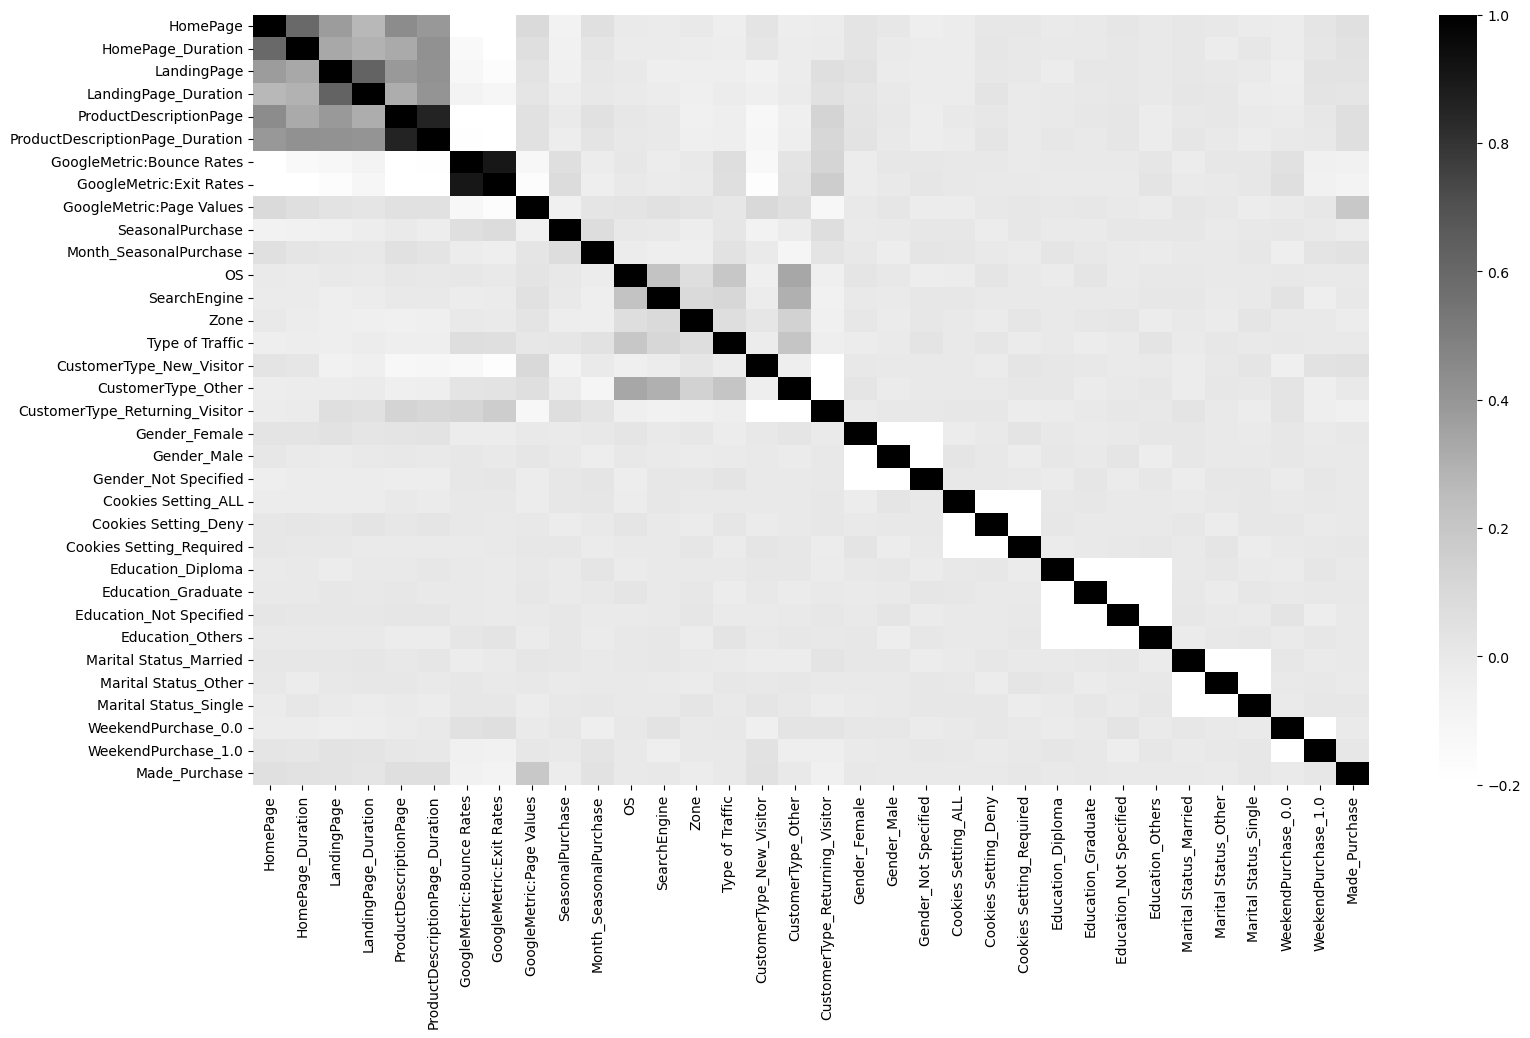

In [241]:
plt.figure(figsize = (18, 10))
sns.heatmap(dataCopy.corr(), annot=False,cmap='Greys', vmin=-0.2, vmax=1);


1. google metric: Page values has most correlation with purchasing after that product description page and duration follows
2. exit rates and bounec rates have negative correlation with purchasing

## Final Pipelines for estimation

#### scaling and feature selection

In [242]:
feature = Pipeline([
    ("scaler", StandardScaler()),
    ("features", SelectPercentile(f_classif, percentile = 5))
])
y = LabelEncoder().fit_transform(y)
X = feature.fit_transform(X, y)
X_test = feature.transform(X_test)

In [243]:
X.shape

(10198, 2)

#### estimation 

In [244]:
# clf = SVC(C=10, class_weight='balanced', probability=True)

# clf1 = LogisticRegression(C=10.0, class_weight='none', intercept_scaling=0, max_iter=800, penalty='none', solver='newton-cg')

# clf = DecisionTreeClassifier(class_weight='balanced', max_features='sqrt')

estimator = AdaBoostClassifier(LogisticRegression(C=10, class_weight='balanced'), n_estimators=100, random_state=0)
# 0.6725483542585681

# clf = HistGradientBoostingClassifier(max_iter=100)
# 0.6603325415676959

# clf = SVC(C=10)
# 0.674355

# clf = VotingClassifier(estimators=[ ('lr', LogisticRegression(C=10, class_weight='balanced')), 
#                                    ('rf', AdaBoostClassifier(n_estimators=100, random_state=0)), 
#                                    ('gnb', HistGradientBoostingClassifier(max_iter=100)), 
#                                    ('svc', SVC(probability=True))
#                                   ], voting='soft')
# 0.671530369867662

In [207]:
estimator.fit(X, y)
y_hat = estimator.predict(X_test)
score1 = estimator.score(X_test, y_test)
score1

0.6329715061058344

In [269]:
# random_state
from sklearn.metrics import make_scorer, roc_auc_score
scorer = make_scorer(roc_auc_score)

seed = 123
# use 10-kfold validation
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)

# create the sub models
estimators = [] # this will be used in the voting classifier 

# create our 3 models
model1 = AdaBoostClassifier(LogisticRegression(C=10, class_weight='balanced'), n_estimators=100, random_state=0)

estimators.append(('ada', model1)) # append it to the estimators 

model3 = xgb
estimators.append(('xgb', model3))

model4 = tuned_clf
estimators.append(('tuned_clf', model3))

# create the voting ensemble model
ensemble = VotingClassifier(estimators)
# validate with cross-validation
results = cross_val_score(ensemble, X, y, cv=kfold, scoring = scorer)
print(results.mean())

0.601718226841796


In [260]:
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_hat)
print(cr)

              precision    recall  f1-score   support

       False       0.68      0.77      0.72       907
        True       0.53      0.41      0.46       567

    accuracy                           0.63      1474
   macro avg       0.60      0.59      0.59      1474
weighted avg       0.62      0.63      0.62      1474



In [261]:
from sklearn.model_selection import ShuffleSplit, RandomizedSearchCV
from sklearn.utils.fixes import loguniform

c= StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=42)
scores = RandomizedSearchCV(estimator,
                            param_distributions={
                                'algorithm': ['SAMME', 'SAMME.R'],
                                'base_estimator__C': np.logspace(-3,3,7),
                                'base_estimator__class_weight': ['balanced', None],
                                'base_estimator__max_iter':list(range(1, 2000)),
                                'base_estimator__penalty': ['l2'], 
                                'base_estimator__random_state':[0, 42, 1729, None], 
                                'base_estimator__solver':['newton-cg', 'lbfgs', 'liblinear'],  
                                'learning_rate': loguniform(1, 10), 
                                'n_estimators': np.arange(10,300,10),
                                'learning_rate': [0.01, 0.05, 0.1, 1], 
                                'random_state':[0, 42, 1729]
                                },
                            cv=5,
                            scoring='accuracy',
                            n_iter=10,
                            n_jobs=-1,
                            error_score = 'raise',
                            refit=True)
scores.fit(X,y);

In [262]:
tuned_clf = scores.best_estimator_
tuned_clf

AdaBoostClassifier(base_estimator=LogisticRegression(C=1000.0, max_iter=548,
                                                     random_state=1729,
                                                     solver='newton-cg'),
                   learning_rate=1, n_estimators=200, random_state=0)

In [263]:
tuned_clf.fit(X, y)
y_hat_tuned = tuned_clf.predict(X_test)
score2 = tuned_clf.score(X_test, y_test)
score2

0.6736770691994572

In [264]:
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_hat_tuned)
print(cr)

              precision    recall  f1-score   support

       False       0.67      0.91      0.78       907
        True       0.68      0.29      0.41       567

    accuracy                           0.67      1474
   macro avg       0.68      0.60      0.59      1474
weighted avg       0.67      0.67      0.63      1474



In [265]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=4 ,max_depth=1, subsample= 0.5, learning_rate=0.1 , objective='binary:logistic')

xgb.fit(X, y)
preds = xgb.predict(X_test)
score3 = xgb.score(X_test, y_test)
cr = classification_report(y_test, preds)
print(cr, score3)

              precision    recall  f1-score   support

       False       0.67      0.90      0.77       907
        True       0.65      0.31      0.42       567

    accuracy                           0.67      1474
   macro avg       0.66      0.60      0.59      1474
weighted avg       0.66      0.67      0.63      1474
 0.669606512890095


### fitting all pipelines on TEST dataset

In [266]:
if score1 > score2:
    if score1 > score3:
        est = estimator
    else:
        est = xgb_pipe
elif score2 > score1:
    if score2 > score3:
        est = tuned_clf
    else:
         est = xgb_pipe
else:
    est = xgb_pipe

In [267]:
test_data = "kaggleData/test_data_v2.csv"
test_df = pd.read_csv(test_data)
test_df = pd.DataFrame(pipe_impute.transform(test_df), columns = columns)
test_df = pd.DataFrame(encoder.transform(test_df), columns = Newcolumns)

y_pred = est.predict(test_df)

output = pd.DataFrame(y_pred.astype(bool))
output = output.reset_index()
output = output.rename(columns = {'index':'id',0:'Made_Purchase'})
output

C:\Users\areeb\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


ValueError: X has 33 features, but AdaBoostClassifier is expecting 2 features as input.

In [108]:
output.Made_Purchase.value_counts()

False    5469
True     1130
Name: Made_Purchase, dtype: int64

In [ ]:
output.to_csv('submission.csv',index = False)